In [1]:
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

import tensorflow as tf

In [2]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

/home/jupyter/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Benchmark: Gaussian Linear

Demonstrates JANA on a toy 10-D Gaussian.

In [3]:
benchmark_name = 'gaussian_linear'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the gaussian_linear model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [4]:
# Explicit settings of the affine coupling layer for future compatibility
# Note: Posterior and likelihood amortizer use identical settings
coupling_settings = {
    'dense_args': dict(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(5e-4)), 
    'dropout_prob': 0.05
}

# Wrapper for posterior and likelihood amortizers
amortizer = AmortizedPosteriorLikelihood(
    AmortizedPosterior(InvertibleNetwork(num_params=10, num_coupling_layers=5, coupling_settings=coupling_settings)),
    AmortizedLikelihood(InvertibleNetwork(num_params=10, num_coupling_layers=5, coupling_settings=coupling_settings))
)

# Training

In [5]:
trainer = Trainer(
    amortizer=amortizer,
    default_lr=1e-3,
    generative_model=benchmark.generative_model,
    configurator=benchmark.configurator,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    max_to_keep=1,
    memory=False
)

INFO:root:Loaded loss history from checkpoints/gaussian_linear/history_50.pkl.
INFO:root:Networks loaded from checkpoints/gaussian_linear/ckpt-50
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training
Uncomment for training. Wall time with GPU: approx. 6min 16s

In [6]:
# EPOCHS = 50
# SIMULATION_BUDGET = 10000
# N_VAL = 300
# BATCH_SIZE = 64
# train_data = trainer.generative_model(SIMULATION_BUDGET)

In [7]:
# %%time
# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Trajectories

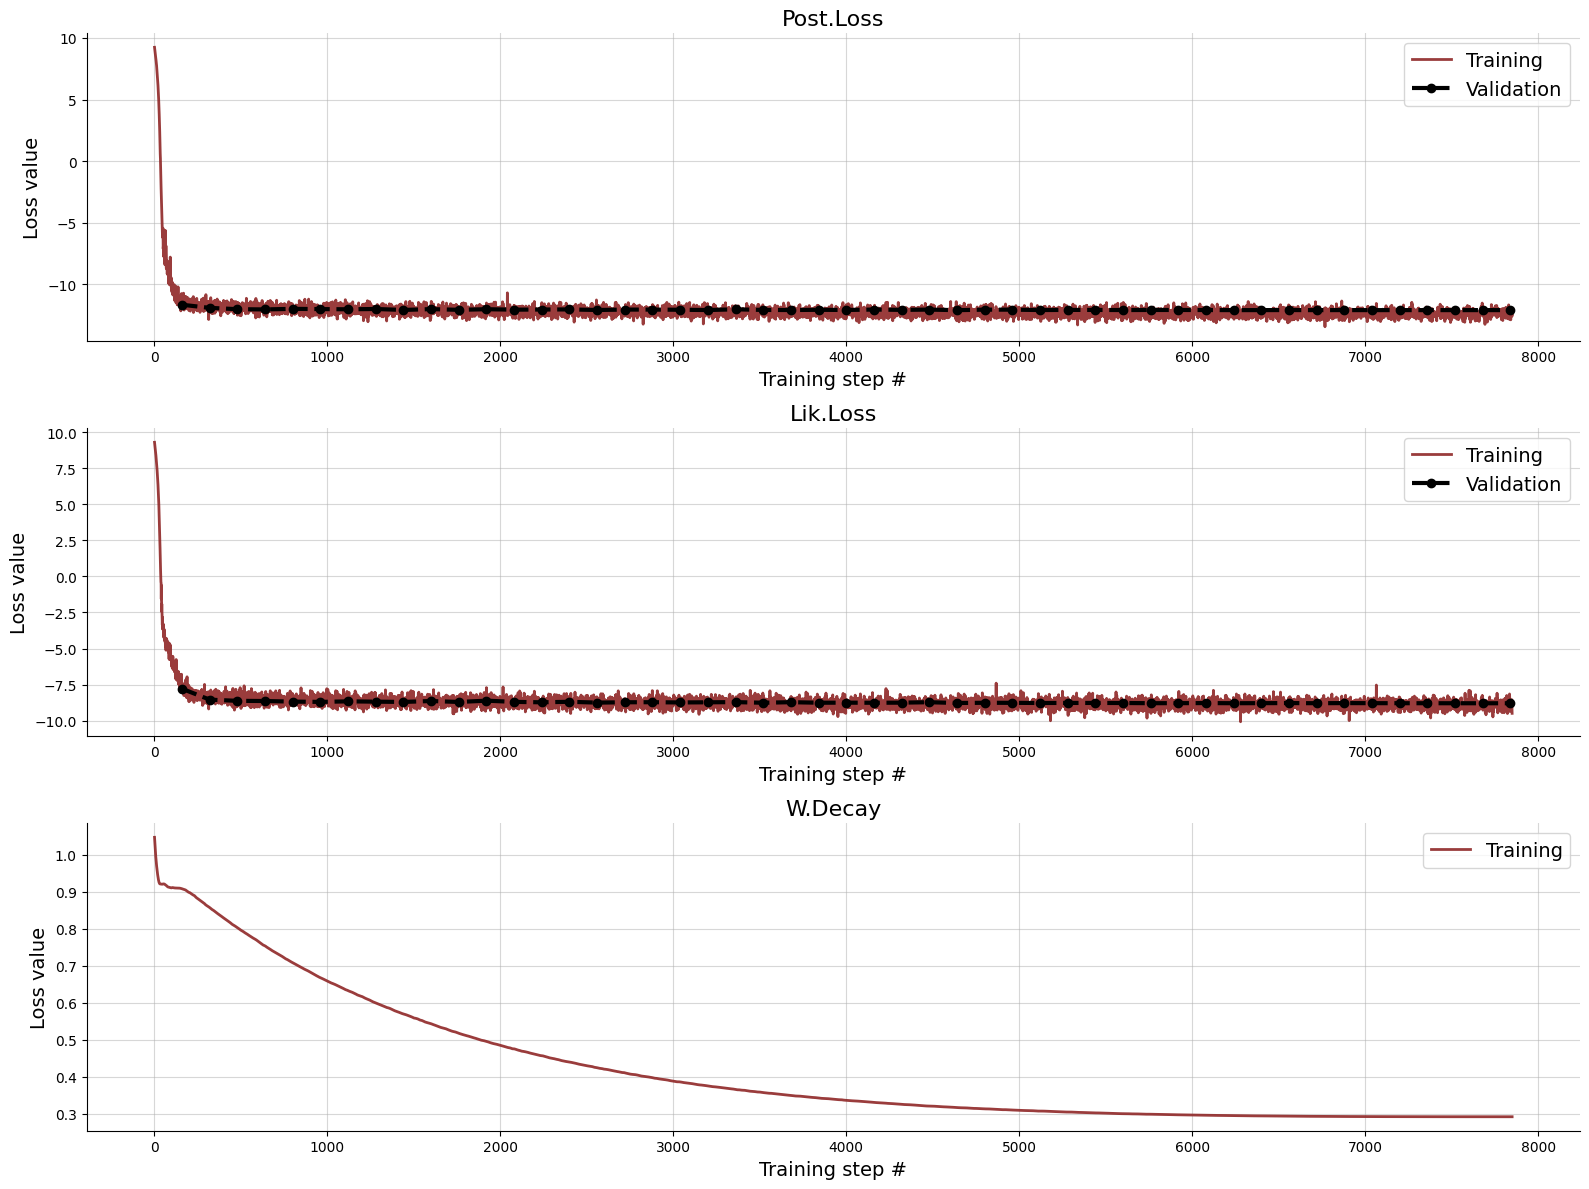

In [8]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

In [9]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [10]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'direct_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

## Individual ECDF Calibration Plots

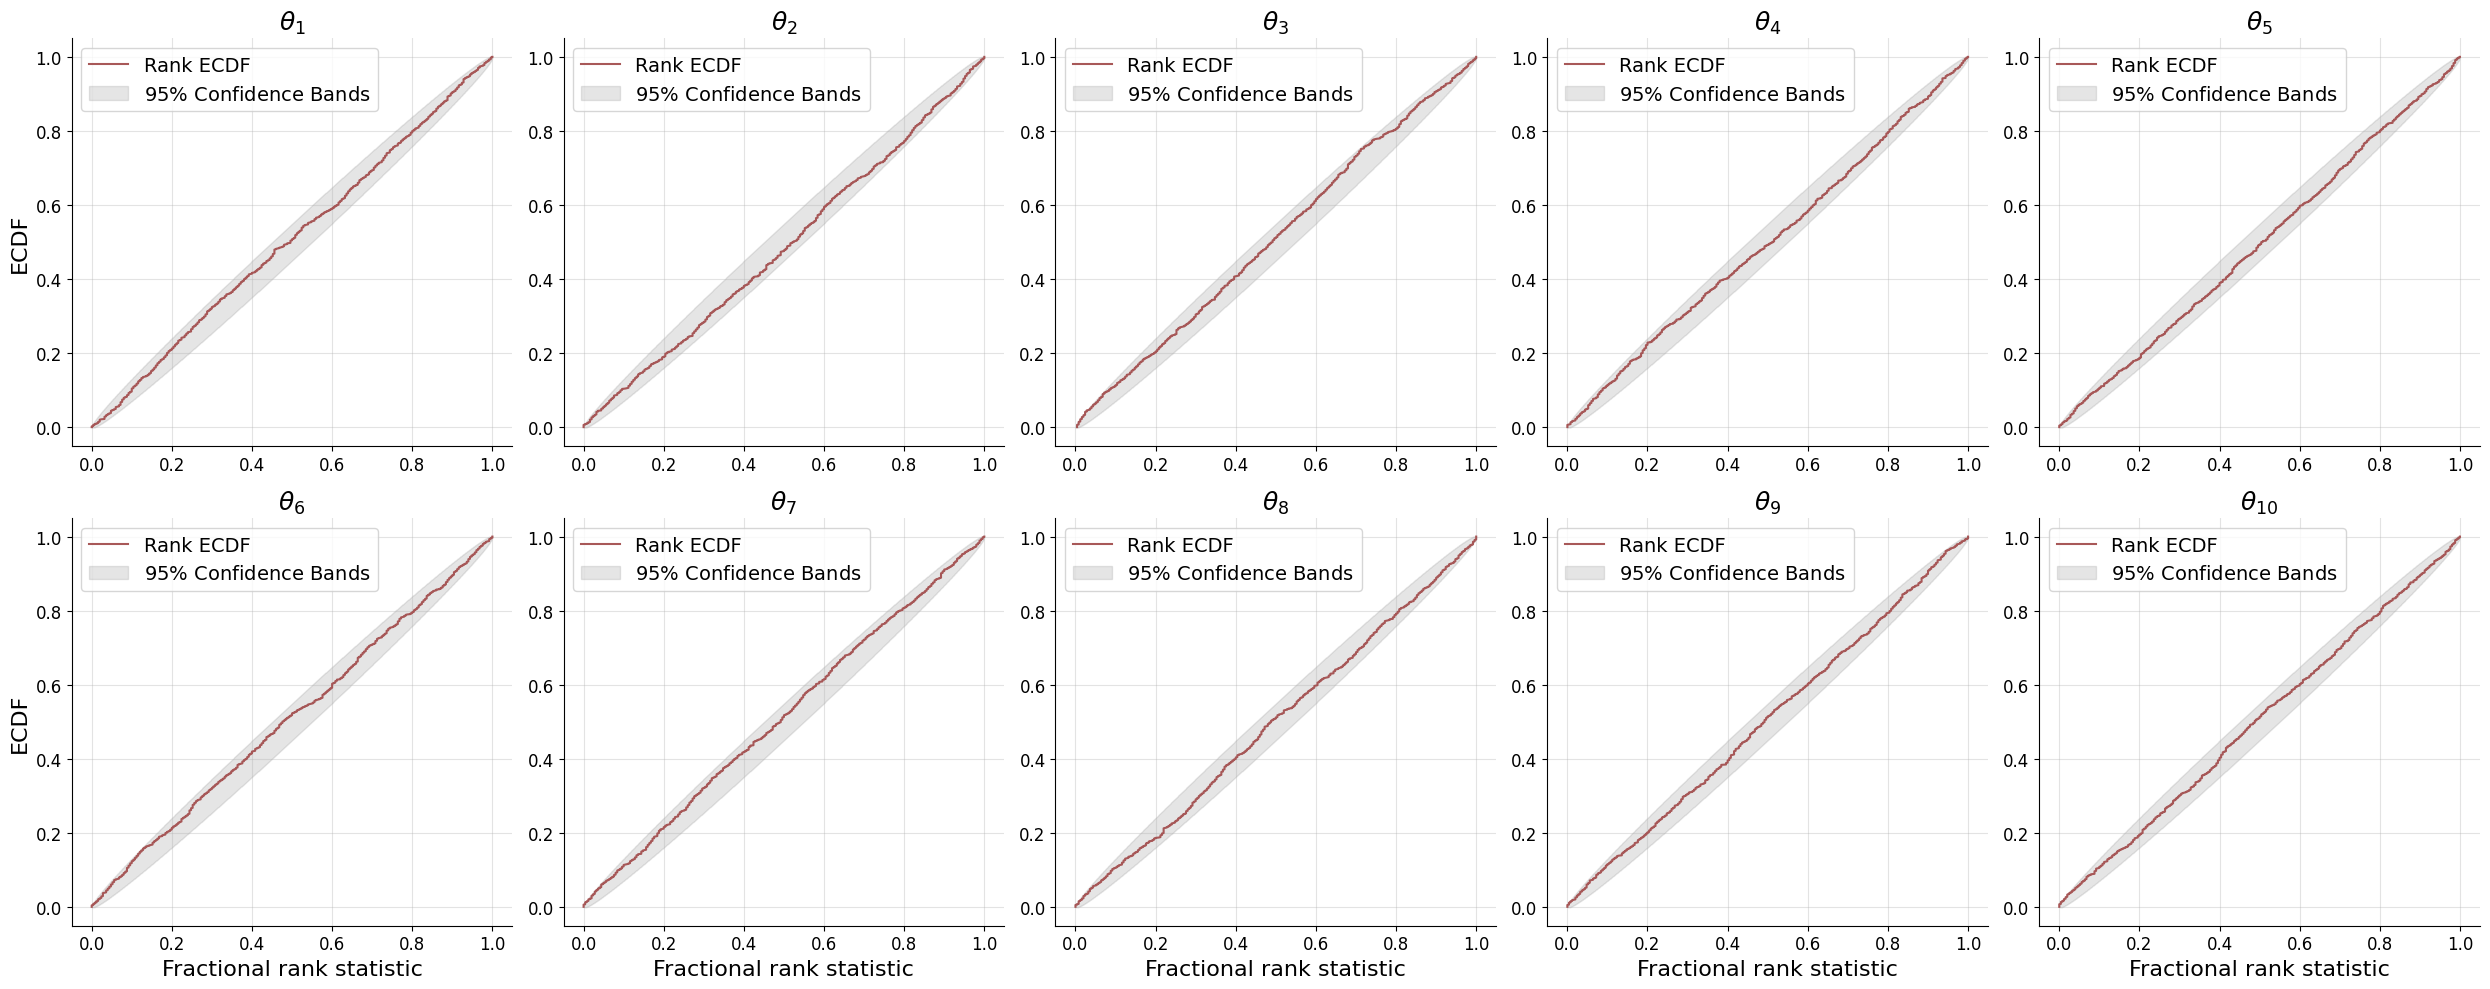

In [11]:
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95))

## Recovery

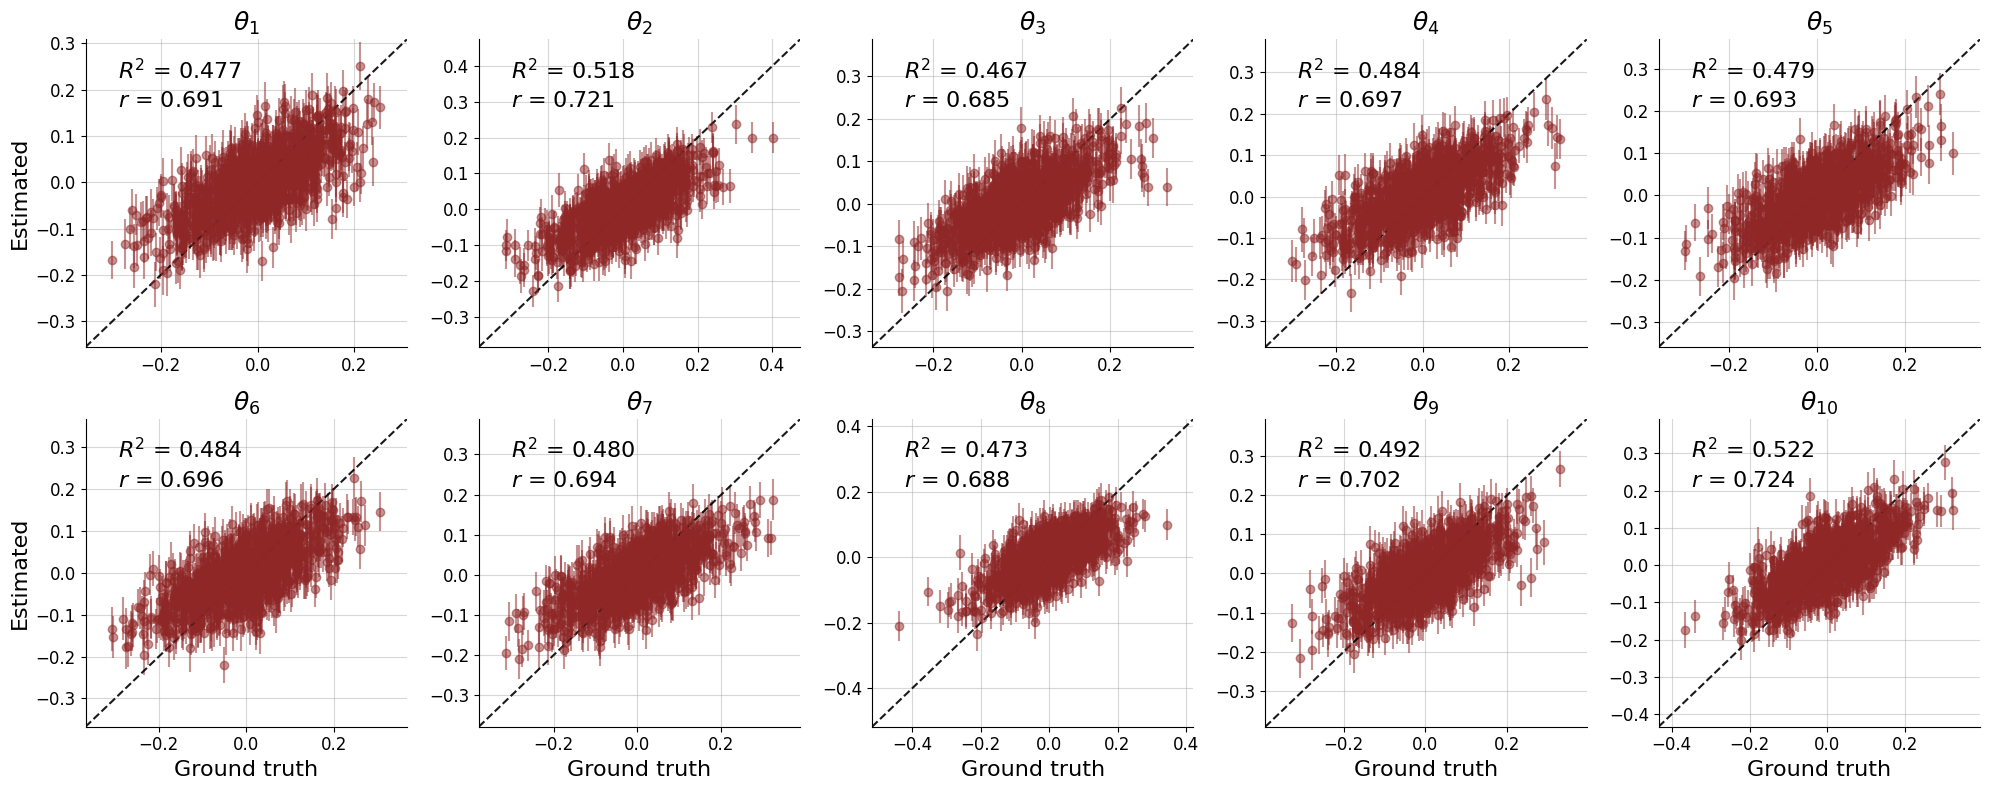

In [12]:
f = plot_recovery(post_samples, prior_samples)

# Appendix Plots

In [13]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

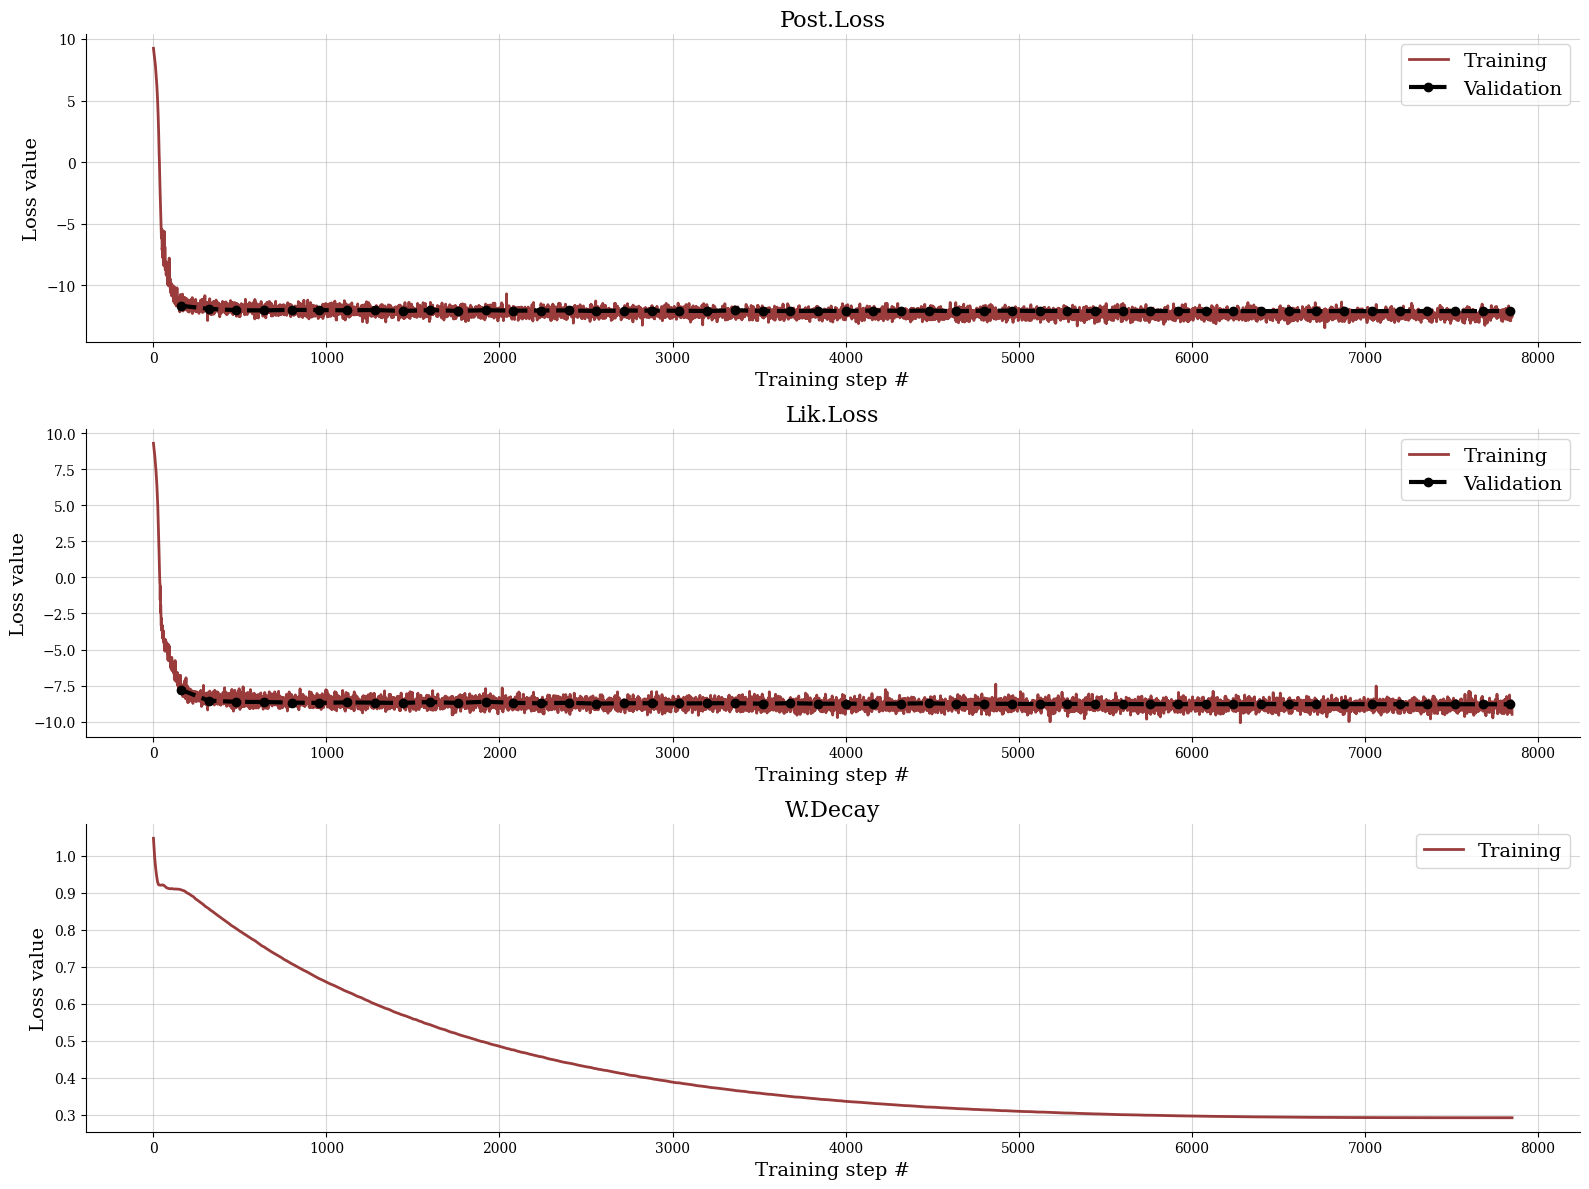

In [14]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

In [15]:
parameter_names = [rf'$\theta_{{{i}}}$' for i in range(1, 11)]

### Posterior Calibration

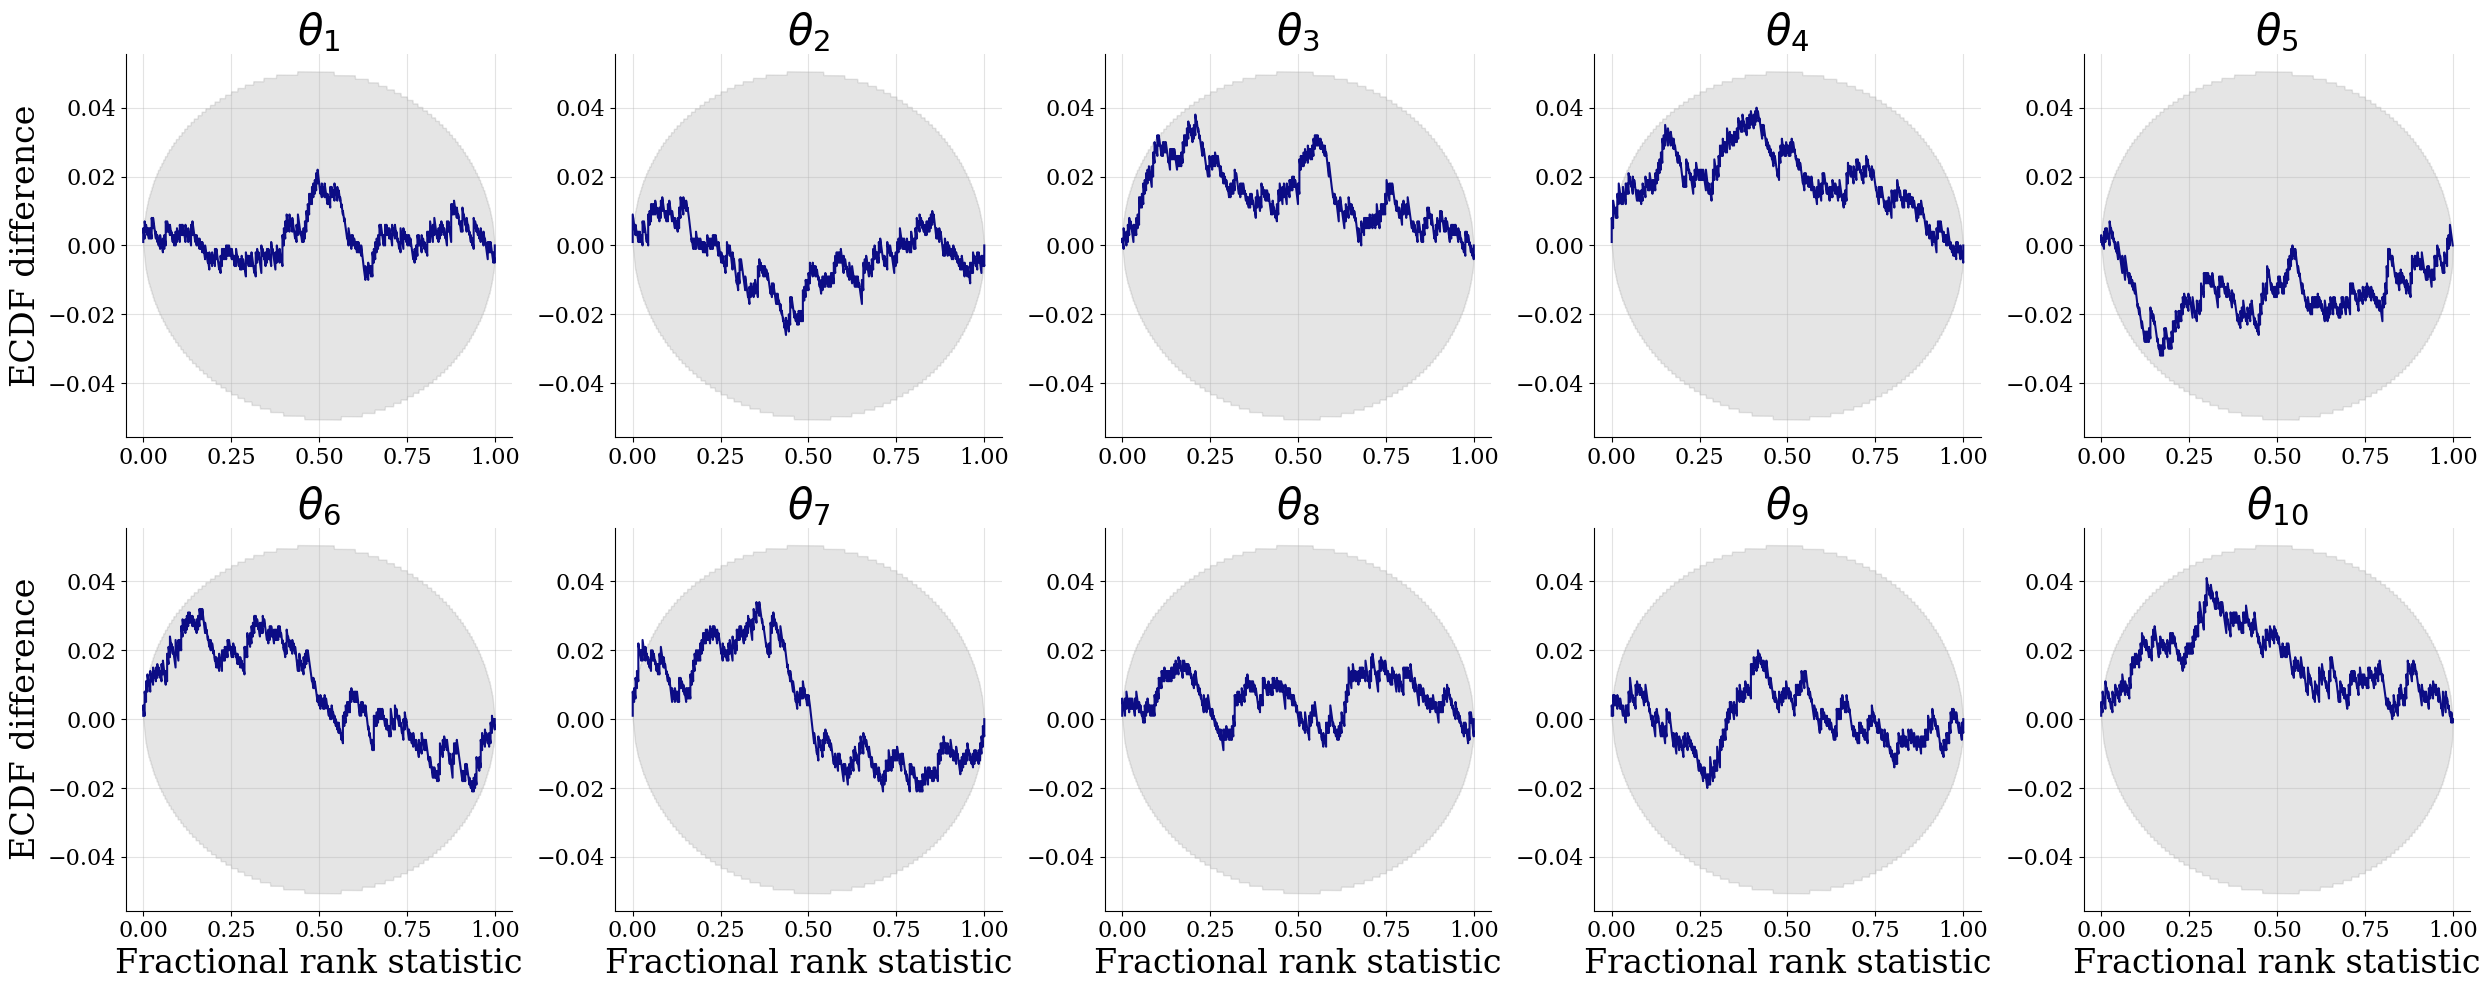

In [16]:
f = plot_sbc_ecdf_appendix(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=parameter_names,
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#000080'
)

plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")

### Joint Calibration

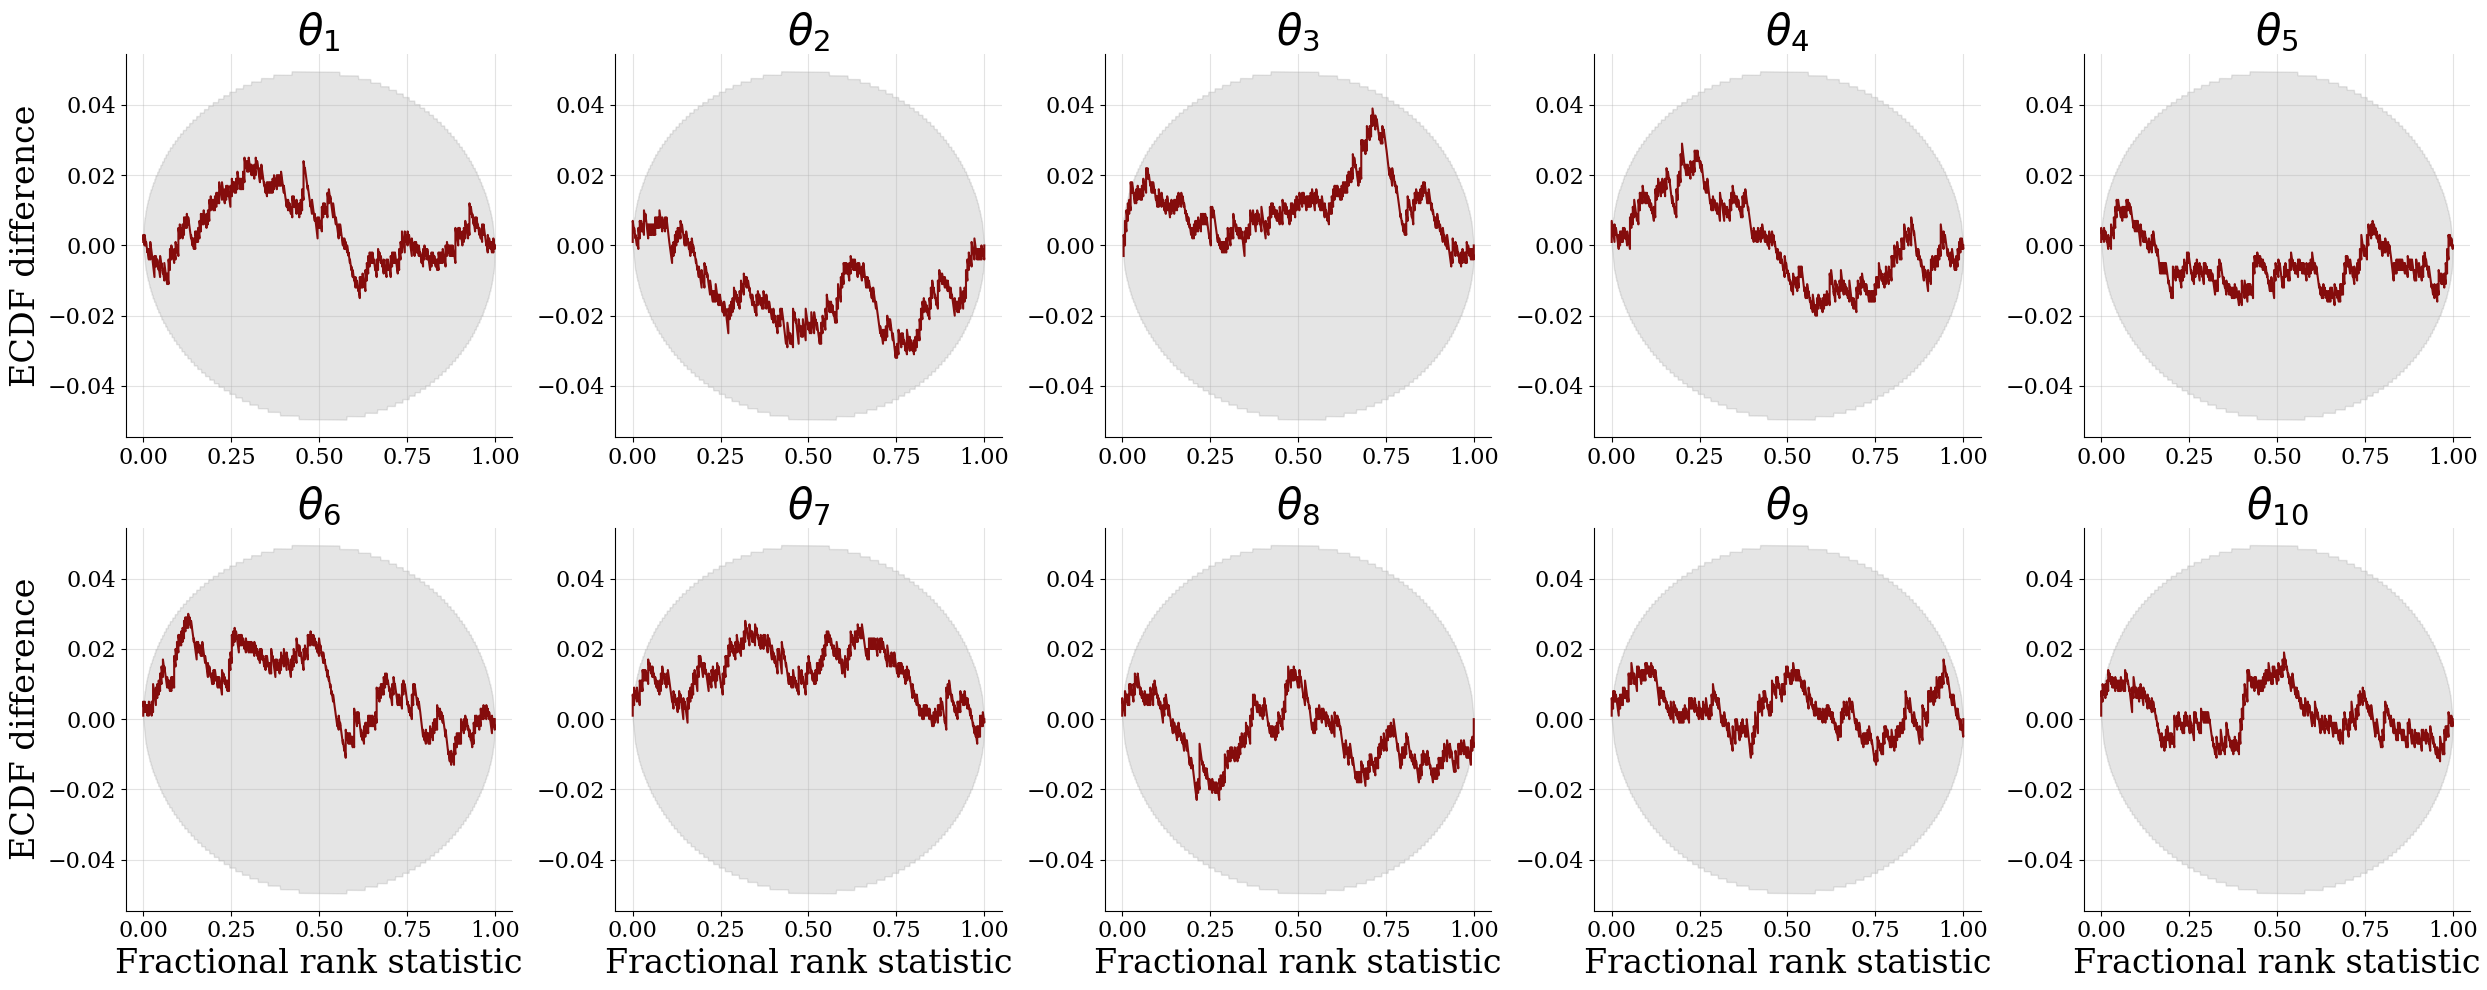

In [17]:
f = plot_sbc_ecdf_appendix(
    post_samples_s, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=parameter_names,
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#800000'
)

plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")